LORA的目标是通过低秩矩阵来减少微调过程中的参数量，从而降低计算资源的需求。lora中低秩矩阵的初始化：A做一个标准正态分布的随机初始化，B初始化为0。
为什么要这么做？
首先，A初始化为标准正态分布是为了保证在训练开始时，A的初始值不会对模型的训练产生太大的影响。因为B初始化为0，所以A初始化为标准正态分布可以保证A和B初始值的差异尽可能的大，从而避免了A初始值对模型训练的影响。
其次，B初始化为0是为了在训练开始时，A和B的初始值差异尽可能的大，从而避免了A初始值对模型训练的影响。
最后，A初始化为标准正态分布，B初始化为0，可以保证在训练开始时，A和B的初始值差异尽可能的大，从而避免了A初始值对模型训练的影响。

motivation:应该尽量减少刚开始训练时的波动，否则会偏离原始矩阵很多，从而导致结果就和原来的偏离很多，当模型层数深了之后就可能有一个传播的效应。会带来训练不稳定。

在原论文中提到过对于两个低秩矩阵,会用超参α(一个常数)来做调整,这个超参是作为scaling rate直接和低
秩矩阵相乘的,也就是最终的输出为:
Wnew = W + (α/r)(BA)
W是原始的预训练权重矩阵。
A是一个rxd的矩阵,其中r是秩,d是权重矩阵的维度。
B是一个dxr的矩阵。
BA是一个dxd的矩阵,它是低秩矩阵A和B的乘积,用于近似全参数微调中的增量权重。
a/r是缩放因子,用于调整低秩矩阵对原始权重的影响程度。
两个可以调的超参数:
1.超参数α:
 a是一个缩放因子,用于控制低秩矩阵对预训练权重更新的灵献程度
。它直接影响到微调过程中新知识(通过低秩矩阵A和B表示)对模型权重的影响大小。
。较大的a值会增加低秩矩阵在更新中的权重,使得模型更倾向向于适应新任务的特征,但也可能引入过拟合
的风险。
。较小的a值会使更新更加保守,减少对预训练权重的改动,不有助于保持模型在新任务上的泛化能力。
2.超参数r:
r定义了低秩矩阵A和B的秩,即这些矩阵可以表示的线性独立向量的数量。秩 决定了低秩矩阵能够捕捉到的特征维度的数量(可以表示矩阵的信息量)。较小的r意味着模型只能
学习到更精炼的特征子集,而较大的r允许模型学习更多的特征维度,但可能会引入更多的噪声。
在LORA中,通过设置较小的秩,可以减少模型需要训练的参数数量,从而降低训练成本和提高训练效率。

In [ ]:
import torch
import torch.nn as nn

class LoRALinear(nn.Module):
    """
    一个简单的LoRA线性层Demo：W_new = W + alpha/r * (BA)
    """
    def __init__(self, in_features, out_features, r=4, alpha=1.0, bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.r = r
        self.alpha = alpha

        # LoRA部分
        self.A = nn.Parameter(torch.randn(r, in_features))  # 标准正态初始化
        self.B = nn.Parameter(torch.zeros(out_features, r)) # 零初始化

        # 缩放因子
        self.scaling = self.alpha / self.r

    def forward(self, x):
        # 原始输出
        result = self.linear(x)
        # LoRA增量
        lora_update = (self.B @ self.A)  # (out_features, in_features)
        result = result + (x @ lora_update.t()) * self.scaling
        return result

# 使用示例
if __name__ == "__main__":
    torch.manual_seed(42)
    lora_layer = LoRALinear(in_features=8, out_features=4, r=2, alpha=8)
    x = torch.randn(3, 8)
    y = lora_layer(x)
    print("输出 shape:", y.shape)
    print("输出:", y)

# AdaLORA
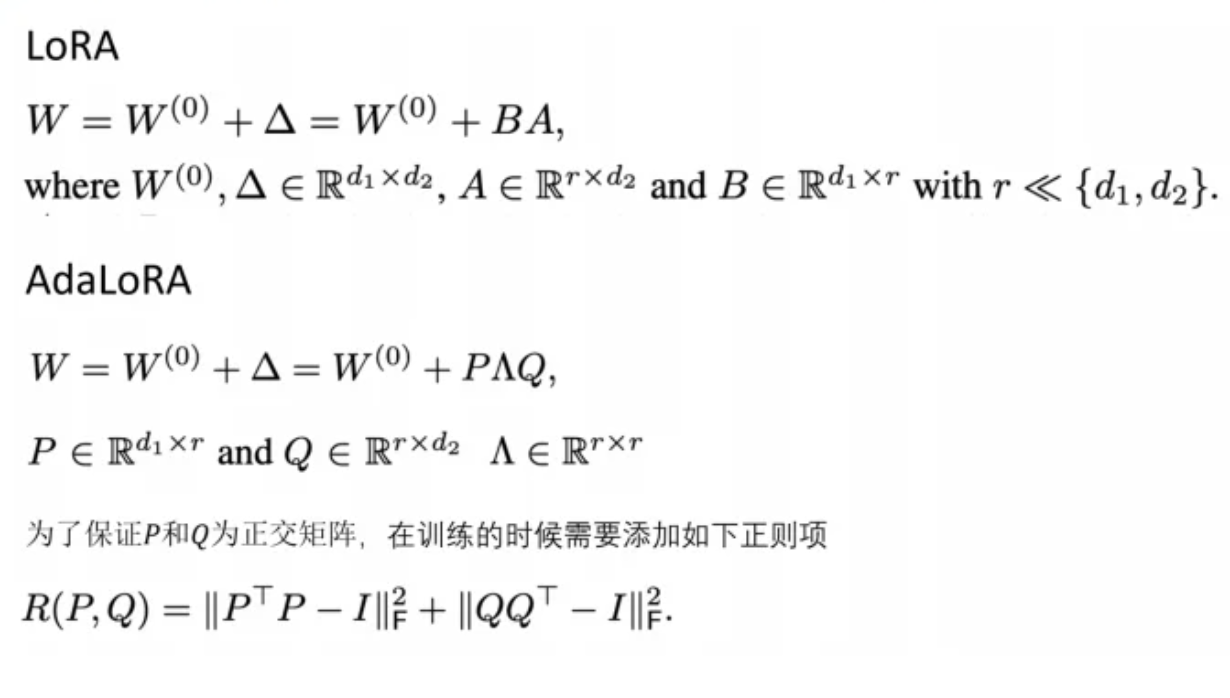

LoRA 通过将权重变化表示为两个低秩矩阵的乘积来进行微调。
AdaLoRA 在 LoRA 的基础上引入了自适应的低秩矩阵，并通过正则项确保矩阵的正交性，从而可能获得更好的优化效果。

daLoRA计算重要性的方法如下：
- **基于SVD的参数化**：AdaLoRA将权重矩阵的增量更新以奇异值分解的形式进行参数化，即  
  $$
  \Delta = P\Lambda Q
  $$
  其中，$\Delta$是增量矩阵，$P$和$Q$是正交矩阵，$\Lambda$是对角矩阵，其对角线上的元素为奇异值。通过这种参数化，避免了密集的精确SVD计算，同时可以通过调节奇异值来控制矩阵的秩，进而控制参数预算。$\Lambda$采用零初始化，$P$和$Q$采用随机高斯初始化，确保$\Delta$最开始等于零。
- **三元组重要性度量**：将增量矩阵$P\Lambda Q$划分为三元组，每个三元组$G_i$包含第$i$个奇异值和对应的奇异向量。为了量化三元组的重要性，AdaLoRA提出了一种新的重要性度量。该度量考虑了$G_i$中每个条目对模型性能的贡献，具体计算会综合考虑奇异值的大小以及与该奇异值相关的梯度信息等，以更全面、准确地评估每个三元组对模型输出的影响程度。具有低重要性分数的三元组会被赋予低优先级，其奇异值会被置零，从而实现对不重要更新的修剪，达到动态调整矩阵秩的目的。

例如，对于一个权重矩阵$W$，经过SVD分解后得到  
$$
W = U\Sigma V^T
$$
AdaLoRA会关注$\Sigma$中的奇异值以及对应的$U$和$V$中的奇异向量所构成的三元组。如果某个三元组的奇异值较小，且根据梯度信息等判断其对模型性能的贡献也较小，那么该三元组的重要性分数就会较低，在训练过程中就可能会被修剪掉，即对应的奇异值被置为零，从而降低了矩阵的秩，减少了参数预

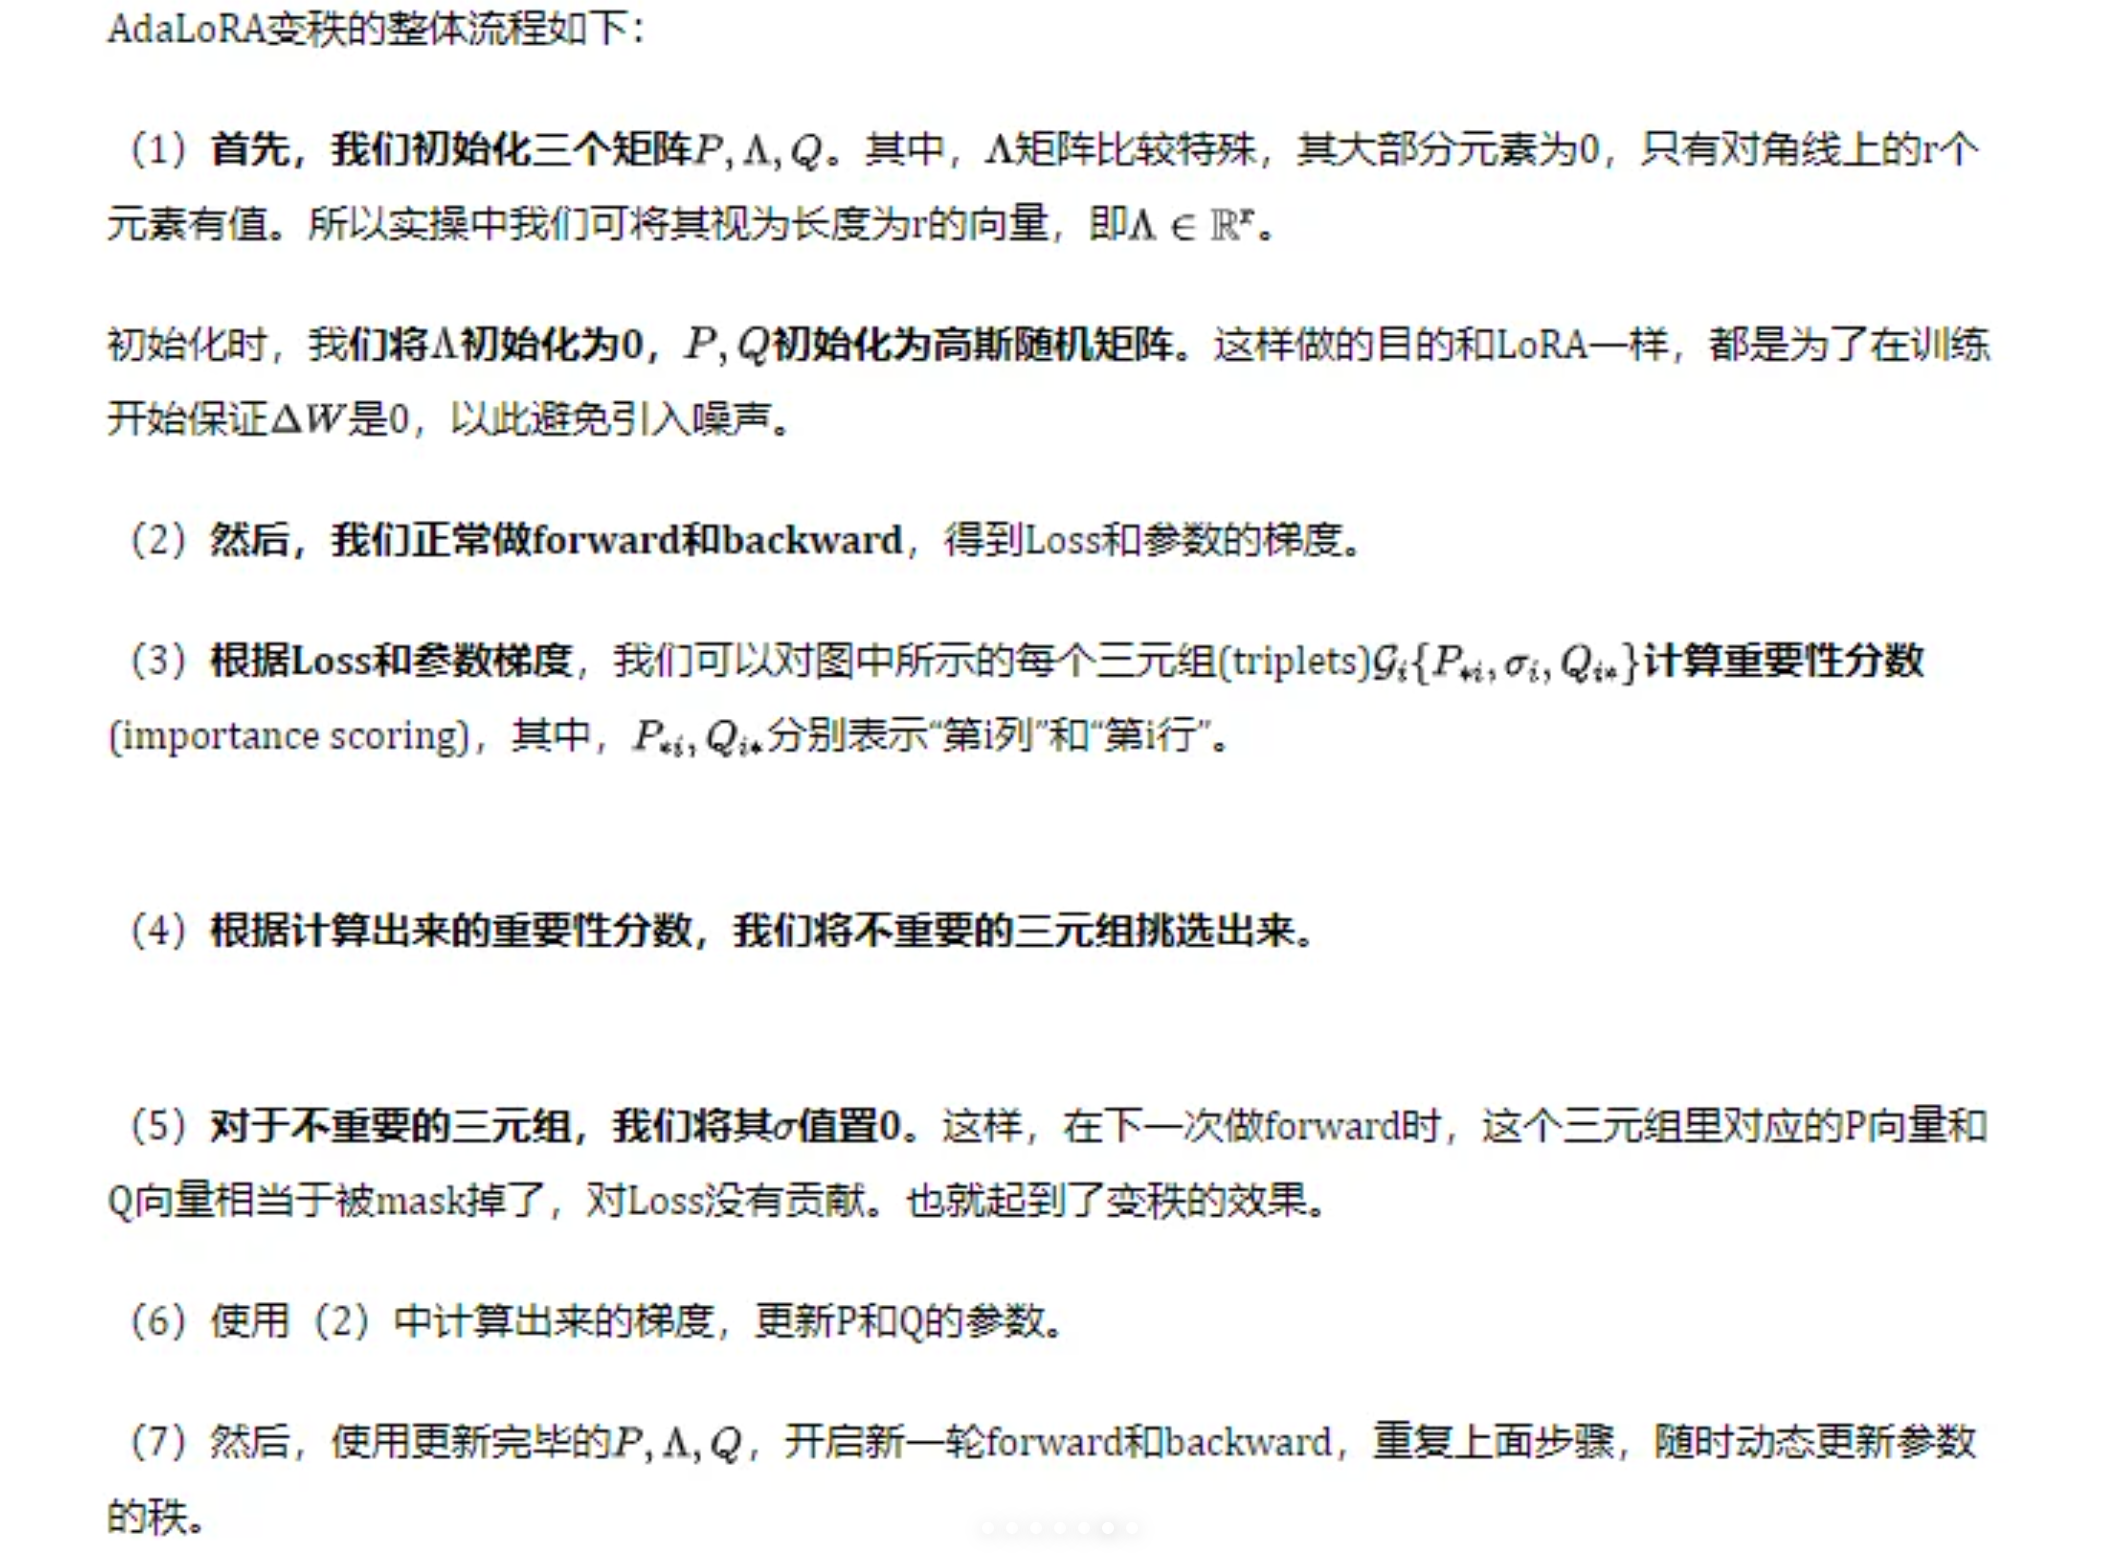

# QLoRA

## QLoRA简介

QLoRA（Quantized Low-Rank Adapter）是一种结合了参数高效微调（PEFT）和量化技术的微调方法。它的核心思想是在大模型参数进行低秩适配（LoRA）的同时，将主模型权重进行低比特量化（如4比特），从而极大降低显存占用，使得在消费级GPU上也能高效微调大模型。

## QLoRA的核心思想

1. **主模型权重量化**  
   - 将大模型的权重（如Transformer的线性层权重）量化为4比特（甚至更低），大幅减少显存占用。
   - 量化权重在前向传播和反向传播时保持不变，不参与梯度更新。

2. **LoRA适配器全精度训练**  
   - 在量化权重的基础上，插入LoRA低秩适配器（A、B矩阵），仅训练这部分参数，且保持全精度（float32/float16）。
   - 这样既能保证微调能力，又不会显著增加显存消耗。

3. **冻结主模型参数**  
   - 量化后的主模型参数在微调过程中保持冻结，仅LoRA参数可训练。

4. **Double Quantization（双量化）**  
   - QLoRA提出了一种双量化技术，进一步压缩权重存储空间，提升大模型加载和训练效率。

## QLoRA的公式

假设原始线性层为 $y = Wx$，QLoRA微调后为：
$$
y = \text{Quant}(W) x + \alpha \cdot BAx
$$
- $\text{Quant}(W)$：量化后的权重矩阵（如4比特）。
- $A, B$：LoRA的低秩矩阵（全精度）。
- $\alpha$：缩放因子。

## QLoRA的优势

- **极低显存占用**：可在单张24GB甚至更小显存的消费级GPU上微调百亿参数大模型。
- **训练速度快**：量化权重不参与反向传播，训练仅涉及LoRA参数。
- **性能接近全参数微调**：实验表明，QLoRA在多项任务上与全参数微调效果接近。
- **支持大多数主流大模型**：如LLaMA、BLOOM、ChatGLM等。

## QLoRA的典型流程

1. 加载预训练大模型，并将其权重量化（如4比特）。
2. 在目标层插入LoRA适配器（A、B矩阵）。
3. 冻结主模型参数，仅训练LoRA参数。
4. 训练完成后，推理时只需加载量化权重和LoRA参数。

## QLoRA的常用实现

- HuggingFace Transformers + PEFT库（`peft.LoraConfig` + `bitsandbytes`量化）
- 官方QLoRA论文实现：[https://github.com/artidoro/qlora](https://github.com/artidoro/qlora)


